<h1 style='text-align: center'>Analysis of Neighborhood Restaurants in London</h1>

<h2><em>1. Inroduction</em></h2>

In this project, we’ll try to solve a problem which usually happens to people who are visiting a new city
which is, what are the good affordable restaurants in a given neighborhood/town that serve good and affordable
cuisines of ones liking? So, the scope of this project will be to provide a list of good restaurants which provide
the cuisine of their choice also it should be hygienic and should have good ratings as well.

Since London is one of the many multicultural cities around the world, we will be comparing the
neighborhoods of London and cumulating a list of restaurants based on the cuisine they serve,
and their ratings. For this to work we’ll rely on data collected from different sources and various types of
visualizations including plotting the areas on the map.

<h2><em>2. Data</em></h2>

<h3>Data Sources</h3>

<ol>
For this project we’ll be gathering public data from following sources:
    <li><b>Wikipedia</b>: Here we can get the data related to boroughs and the locations within those boroughs. Since this data is based on the locations under each boroughs in London, we can group these areas based on the boroughs they belong to. Click <a href = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'>here</a> to visit the Wikipedia page.</li>
    <li><b>Foursquare</b>: Using Foursquare API we can obtain longitudes and latitudes of all the boroughs and
    using that data we can plot the locations and popular venues in London. Also using this API, we
    can also get the details of all the restaurants that serve different types of cuisines from around
    the world.</li>
    <li><b>Data World</b>: Using Data World we can get the detailed information about the venues which we'll get from Foursquare API like for example ratings.
</ol>

<h2><em>3. Methodology</em></h3>

#### Importing necessary packages

In [1]:
# Data imports
import pandas as pd
import numpy as np

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Webpage scraping imports
import urllib.request
from bs4 import BeautifulSoup
import requests

# Imports to transform from JSON data to Pandas DataFrame
from pandas.io.json import json_normalize

# Import for reading a JSON file 
import json

# Import for getting location coordinates
import geocoder

# Import for creating and plotting the data on a map
import folium

# Import for getting the coordinates of the given location
from geopy.geocoders import Nominatim

import time

#### Getting necessary API credentials

In [2]:
#Getting foursquare credentials
f=open('credentials.json',)
cred = json.load(f)
f.close()
VERSION = '20180605' # Foursquare API version

#### Predefining required functions

In [3]:
#creating a function that gets a nearby venues for the given location
def getVenues(name,latitude,longitude,radius=500):
    venues_list=[]
    limit=100
    for name,lat,lng in zip(name,latitude,longitude):
        #creating API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            cred['4square']['CLIENT_ID'], 
            cred['4square']['CLIENT_SECRET'], 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        
        #creating a GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #appending the relevant values in venue list
        venues_list.append([(
            name, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 'Venue','Venue ID', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

def create_map(address,df,color):
    # Getting the corrdinates of Camden using address
    geolocator = Nominatim(user_agent="map")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude

    # Creating a map of Westmister
    Map = folium.Map(location=[latitude, longitude], zoom_start=10)

    # Plotting all the locations on the map
    for lat, lng, borough, neighborhood in zip(df['Venue Latitude'], df['Venue Longitude'], df['Venue'], df['Location']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(Map)  

    return Map

# function that returns coordinates for given postal code
def get_coordinates(postalCode):
    coords = None
    while(coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(postalCode))
        coords = g.latlng
    return coords

#### Scraping the web data from Wikipedia

In [4]:
#URL for wikipedia data
url='https://en.wikipedia.org/wiki/List_of_areas_of_London'

# opening the URL using urllib.request.uropen() method into the page variable
page = urllib.request.urlopen(url)

# parsing the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page,'lxml')
soup.prettify()

# using 'find_all' function, we can bring back all instances of the 'table' especially,
# under tbody tag in the HTML and store it in a variable
ldn_table = soup.find('table',class_ = 'wikitable sortable').tbody

#creating an area list for our data from table in wikipedia page
area_list = [[],[],[],[],[],[]]

# appending the data from wikipedia into out area list 
for row in ldn_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==6:
        for i in range(6):
            area_list[i].append(cells[i].find(text=True).strip())

# creating a list for column names
column_names = ['Location','Boroughs','Post Town','Postcode','Dial Code','OS grid ref']

# creating a DataFrame from our list
london_df = pd.DataFrame(columns=column_names)
for i in range(len(column_names)):
    london_df[column_names[i]] = area_list[i]
london_df

,Location,Boroughs,Post Town,Postcode,Dial Code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728
...,...,...,...,...,...,...
528,Woolwich,Greenwich,LONDON,SE18,020,TQ435795
529,Worcester Park,"Sutton, Kingston upon Thames",WORCESTER PARK,KT4,020,TQ225655
530,Wormwood Scrubs,Hammersmith and Fulham,LONDON,W12,020,TQ225815
531,Yeading,Hillingdon,HAYES,UB4,020,TQ115825


Since we won't be using Dial Code and OS grid ref columns in this project, we'll drop those columns

In [5]:
london_df.drop(['Dial Code','OS grid ref'],axis=1,inplace=True)
london_df

,Location,Boroughs,Post Town,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4"
2,Addington,Croydon,CROYDON,CR0
3,Addiscombe,Croydon,CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14"
...,...,...,...,...
528,Woolwich,Greenwich,LONDON,SE18
529,Worcester Park,"Sutton, Kingston upon Thames",WORCESTER PARK,KT4
530,Wormwood Scrubs,Hammersmith and Fulham,LONDON,W12
531,Yeading,Hillingdon,HAYES,UB4


Removing all the locations from the DataFrame which don't have London as its Post Town

In [6]:
london_df = london_df[london_df['Post Town']=='LONDON']
london_df

,Location,Boroughs,Post Town,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4"
6,Aldgate,City,LONDON,EC3
7,Aldwych,Westminster,LONDON,WC2
9,Anerley,Bromley,LONDON,SE20
...,...,...,...,...
522,Wood Green,Haringey,LONDON,N22
523,Woodford,Redbridge,LONDON,"IG8, E18"
527,Woodside Park,Barnet,LONDON,N12
528,Woolwich,Greenwich,LONDON,SE18


Getting the a count for number of locations under each borough

In [7]:
london_df['Boroughs'].value_counts()

Barnet                                      25
Tower Hamlets                               21
Westminster                                 19
Hackney                                     18
Lewisham                                    17
Camden                                      17
Haringey                                    15
Islington                                   14
Southwark                                   13
Newham                                      13
Greenwich                                   13
Brent                                       11
Lambeth                                     10
Wandsworth                                  10
Hammersmith and Fulham                       9
Kensington and Chelsea                       9
Waltham Forest                               8
Enfield                                      6
Merton                                       5
Richmond upon Thames                         4
Bromley                                      4
Croydon      

The result above shows us that Boroughs like Barnet, Tower Hamlets, Westminster and Hackney etc have higher number of locations than others.

For our project we'll be choosing locations of Camden.

In [8]:
#creating a new dataframe for the locations of Camden.
camden_df = london_df[london_df['Boroughs']=='Camden']
camden_df

,Location,Boroughs,Post Town,Postcode
39,Belsize Park,Camden,LONDON,NW3
54,Bloomsbury,Camden,LONDON,WC1
76,Camden Town,Camden,LONDON,NW1
86,Chalk Farm,Camden,LONDON,NW1
174,Fitzrovia,Camden,LONDON,W1
182,Frognal,Camden,LONDON,NW3
192,Gospel Oak,Camden,LONDON,"NW5, NW3"
210,Hampstead,Camden,LONDON,NW3
239,Highgate,Camden,LONDON,N6
242,Holborn,Camden,LONDON,"WC1, WC2"


Adding coordinates to each of the locations in dataframe

In [9]:
#creating a list for getting all the coordinates
postalCodes,coordinates = camden_df['Postcode'].tolist(),[[],[]]

for postcode in postalCodes:
    coor = get_coordinates(postcode)
    coordinates[0].append(coor[0])
    coordinates[1].append(coor[1])
    
camden_df['Latitude'] = coordinates[0]
camden_df['Longitude'] = coordinates[1]
camden_df

<ipython-input-9-c4059d8a8e52>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  camden_df['Latitude'] = coordinates[0]
<ipython-input-9-c4059d8a8e52>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  camden_df['Longitude'] = coordinates[1]


,Location,Boroughs,Post Town,Postcode,Latitude,Longitude
39,Belsize Park,Camden,LONDON,NW3,51.55506,-0.17348
54,Bloomsbury,Camden,LONDON,WC1,51.52450,-0.12273
76,Camden Town,Camden,LONDON,NW1,51.53354,-0.14606
86,Chalk Farm,Camden,LONDON,NW1,51.53354,-0.14606
174,Fitzrovia,Camden,LONDON,W1,51.51656,-0.14770
182,Frognal,Camden,LONDON,NW3,51.55506,-0.17348
192,Gospel Oak,Camden,LONDON,"NW5, NW3",51.55506,-0.17348
210,Hampstead,Camden,LONDON,NW3,51.55506,-0.17348
239,Highgate,Camden,LONDON,N6,51.57145,-0.14983
242,Holborn,Camden,LONDON,"WC1, WC2",51.52450,-0.12273


#### Getting top restaurant venues in Westminster

In [10]:
#Getting all the venues in Westminster
camden_venues = getVenues(name=camden_df['Location'],
                                   latitude=camden_df['Latitude'],
                                   longitude=camden_df['Longitude']
                                  )
camden_venues

,Location,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Belsize Park,La Crêperie de Hampstead,4af1872cf964a5203de121e3,51.555909,-0.177051,Creperie
1,Belsize Park,Patara,574ad2b5498e49a138716f26,51.555497,-0.176086,Thai Restaurant
2,Belsize Park,Waterstones,4b5306b9f964a520ee8c27e3,51.556080,-0.177492,Bookstore
3,Belsize Park,Roni's Bagel Bakery,5207904511d21d83cf903184,51.554894,-0.172946,Bagel Shop
4,Belsize Park,28 Church Row,579b97f6498e51784c2028e0,51.555610,-0.178724,Tapas Restaurant
...,...,...,...,...,...,...
826,West Hampstead,Speedy Noodle,4bbf963074a9a59345b6cef6,51.542741,-0.198992,Asian Restaurant
827,West Hampstead,McDonald's,4b7800e8f964a520bbb12ee3,51.539607,-0.195667,Fast Food Restaurant
828,West Hampstead,Brondesbury London Overground Station,5036b367cc6417d4bcd9a123,51.545242,-0.202274,Train Station
829,West Hampstead,The Kilburn Arms,4d03c6928620224b7204a540,51.540880,-0.204745,Pub


Since our dataframe has a lot of venues which are not restaurants, we have to clean our dataframe to have only restaurant data in our dataframe

In [11]:
# This will create a new column and assign True to restaurants and False to the venues that are not restaurants
camden_venues['Restaurants?'] = camden_venues['Venue Category'].str.contains('Restaurant',case=False)

# Removing the venues which have False value for the column 'Restaurants?'
camden_restaurants = camden_venues[camden_venues['Restaurants?']==True]

# Dropping the column 'Restaurants?'
camden_restaurants.drop('Restaurants?',axis=1,inplace=True)
camden_restaurants

c:\users\ebinp\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Location,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
1,Belsize Park,Patara,574ad2b5498e49a138716f26,51.555497,-0.176086,Thai Restaurant
4,Belsize Park,28 Church Row,579b97f6498e51784c2028e0,51.555610,-0.178724,Tapas Restaurant
9,Belsize Park,Jin Kichi | 人吉 (Jin Kichi),4b0e428af964a5206d5623e3,51.557211,-0.178370,Japanese Restaurant
18,Belsize Park,Paradise,4baa6ff3f964a520106a3ae3,51.555476,-0.166312,Indian Restaurant
21,Belsize Park,Spielburger,5377c796498e21d3bd43dbc0,51.556336,-0.178640,American Restaurant
...,...,...,...,...,...,...
817,West Hampstead,Nando's,4c1e5386fcf8c9b66e10ad0b,51.544655,-0.200661,Portuguese Restaurant
818,West Hampstead,Ruchi,4bc6045c42419521116f031d,51.543091,-0.195521,Indian Restaurant
825,West Hampstead,Vijay India,4c13af69a9c220a1f121569d,51.540883,-0.201734,Indian Restaurant
826,West Hampstead,Speedy Noodle,4bbf963074a9a59345b6cef6,51.542741,-0.198992,Asian Restaurant


So, now our dataframe has only venues that are restaurants. 

Let's see what are the different type of restaurants in our dataframe

In [12]:
camden_restaurants['Venue Category'].value_counts()

Italian Restaurant               31
Japanese Restaurant              16
Sushi Restaurant                 14
Indian Restaurant                12
French Restaurant                11
Thai Restaurant                  10
Tapas Restaurant                  9
Argentinian Restaurant            7
Fast Food Restaurant              6
Falafel Restaurant                6
English Restaurant                6
Asian Restaurant                  6
Dim Sum Restaurant                5
American Restaurant               5
Restaurant                        5
Turkish Restaurant                5
Seafood Restaurant                3
Szechuan Restaurant               3
Ethiopian Restaurant              2
Chinese Restaurant                2
Korean Restaurant                 2
Brazilian Restaurant              2
Vegetarian / Vegan Restaurant     2
Lebanese Restaurant               1
Middle Eastern Restaurant         1
Kebab Restaurant                  1
Portuguese Restaurant             1
Okonomiyaki Restaurant      

Let's create dataframe out of the csv file which we get from Data World

In [13]:
# Reading the csv file and creating a DataFrame
dataWorld_df = pd.read_csv('download-1.csv')
dataWorld_df

,Business Name,Address Line 1,Address Line 2,Address Line 3,Postcode,Business Type ID,Business Type Description,Food Hygiene Rating Scheme ID,Food Hygiene Rating Scheme Type,Hygiene Score,...,Easting,Northing,Longitude,Latitude,Spatial Accuracy,Last Uploaded,Location,Organisation URI,:@computed_region_hxwp_gyfc,:@computed_region_6i9a_26nj
0,Wafflelollies.co.uk,NaN,NaN,NaN,NaN,7841,Other catering premises,1085441,FHRS,0.0,...,NaN,NaN,NaN,NaN,Unknown,12/01/2020,NaN,http://opendatacommunities.org/id/london-borou...,NaN,NaN
1,Hotel Chocolat,"Unit Cg04b Western Concourse, Kings Cross Rail...",Euston Road,NaN,N1 9AP,4613,Retailers - other,470876,FHRS,0.0,...,NaN,NaN,NaN,NaN,Unknown,12/01/2020,NaN,http://opendatacommunities.org/id/london-borou...,NaN,NaN
2,Spence Bakery,NaN,NaN,NaN,NaN,7839,Manufacturers/packers,1029677,FHRS,5.0,...,NaN,NaN,NaN,NaN,Unknown,12/01/2020,NaN,http://opendatacommunities.org/id/london-borou...,NaN,NaN
3,Yum Chaa,NaN,1 Granary Square,NaN,N1C 1FA,1,Restaurant/Cafe/Canteen,1068797,FHRS,5.0,...,NaN,NaN,NaN,NaN,Unknown,12/01/2020,NaN,http://opendatacommunities.org/id/london-borou...,NaN,NaN
4,Oliver Bonas,Kings Cross Railway Station,Euston Road,NaN,N1 9AP,4613,Retailers - other,1199661,FHRS,NaN,...,NaN,NaN,NaN,NaN,Unknown,12/01/2020,NaN,http://opendatacommunities.org/id/london-borou...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3096,Miel Bakery,NaN,57 Warren Street,NaN,W1T 5NR,7839,Manufacturers/packers,1152035,FHRS,10.0,...,529144.0,182230.0,-0.139853,51.524221,Unknown,12/01/2020,"(51.524221, -0.139853)",http://opendatacommunities.org/id/london-borou...,2.0,13.0
3097,Pesantissimo Restaurant,NaN,57 Regent's Park Road,NaN,NW1 8XD,1,Restaurant/Cafe/Canteen,425909,FHRS,5.0,...,527855.0,184049.0,-0.157758,51.540868,Unknown,12/01/2020,"(51.540868, -0.157758)",http://opendatacommunities.org/id/london-borou...,3.0,18.0
3098,Wagamama,"Cafe And Premises At Unit 8c Level 2, The O2 C...",255 Finchley Road,NaN,NW3 6LU,1,Restaurant/Cafe/Canteen,717327,FHRS,0.0,...,526194.0,184796.0,-0.181428,51.547955,Unknown,12/01/2020,"(51.547955, -0.181428)",http://opendatacommunities.org/id/london-borou...,18.0,131.0
3099,Area Camden,NaN,NaN,NaN,NaN,4613,Retailers - other,1054004,FHRS,5.0,...,NaN,NaN,NaN,NaN,Unknown,12/01/2020,NaN,http://opendatacommunities.org/id/london-borou...,NaN,NaN


In [14]:
# Let's see what are all the different columns under this DataFrame
dataWorld_df.columns

Index(['Business Name', 'Address Line 1', 'Address Line 2', 'Address Line 3',
       'Postcode', 'Business Type ID', 'Business Type Description',
       'Food Hygiene Rating Scheme ID', 'Food Hygiene Rating Scheme Type',
       'Hygiene Score', 'Structural Score', 'Confidence In Management Score',
       'Rating Value', 'Rating Date', 'New Rating Pending',
       'Local Authority Business ID', 'Local Authority Code',
       'Local Authority Name', 'Local Authority Email Address',
       'Local Authority Website', 'Ward Code', 'Ward Name', 'Easting',
       'Northing', 'Longitude', 'Latitude', 'Spatial Accuracy',
       'Last Uploaded', 'Location', 'Organisation URI',
       ':@computed_region_hxwp_gyfc', ':@computed_region_6i9a_26nj'],
      dtype='object')

In [15]:
result = [] 
for venue in camden_restaurants['Venue']:
    if venue in dataWorld_df['Business Name'].tolist():
        result.append(venue)
camden_restaurants = camden_restaurants[camden_restaurants['Venue'].isin(result)]
camden_restaurants

,Location,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
4,Belsize Park,28 Church Row,579b97f6498e51784c2028e0,51.555610,-0.178724,Tapas Restaurant
21,Belsize Park,Spielburger,5377c796498e21d3bd43dbc0,51.556336,-0.178640,American Restaurant
25,Belsize Park,Dim T,4b52fa6ff964a520d38b27e3,51.555292,-0.178349,Dim Sum Restaurant
29,Belsize Park,Carluccio's,4c0c9d27c700c9b6f730a1dd,51.554650,-0.172220,Italian Restaurant
38,Belsize Park,Fish Cafe,5309e88811d2e2fbd759bcd8,51.555995,-0.177251,English Restaurant
...,...,...,...,...,...,...
797,Swiss Cottage,Sushi Hana,592a02be9cadd90528a3b241,51.556510,-0.177733,Sushi Restaurant
808,West Hampstead,Bombay Flame,4ba8be95f964a5209eeb39e3,51.542676,-0.195202,Indian Restaurant
810,West Hampstead,German Doner Kebab,58a8b2229168024c86918f9a,51.544297,-0.200867,Doner Restaurant
817,West Hampstead,Nando's,4c1e5386fcf8c9b66e10ad0b,51.544655,-0.200661,Portuguese Restaurant


So, the above lines of code will compare will filter out the restaurants that are common in both DataFrames

Now adding HygineScore, StructuralScore, RestaurantRating to our camden_restaurants dataframe

In [16]:
ratings = {'RestaurantRating':[],'HygieneScore':[],'StructuralScore':[]}
for venue in camden_restaurants['Venue']:
    index = dataWorld_df[dataWorld_df['Business Name']==venue].index.values[0]
    ratings['RestaurantRating'].append(int(dataWorld_df.loc[index,'Rating Value']))
    ratings['HygieneScore'].append(int(dataWorld_df.loc[index,'Hygiene Score']))
    ratings['StructuralScore'].append(int(dataWorld_df.loc[index,'Structural Score']))

camden_restaurants['RestaurantRating'] = ratings['RestaurantRating']
camden_restaurants['HygieneScore'] = ratings['HygieneScore']
camden_restaurants['StructuralScore'] = ratings['StructuralScore']

camden_restaurants

<ipython-input-16-37ccd5c0bba5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  camden_restaurants['RestaurantRating'] = ratings['RestaurantRating']
<ipython-input-16-37ccd5c0bba5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  camden_restaurants['HygieneScore'] = ratings['HygieneScore']
<ipython-input-16-37ccd5c0bba5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,Location,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,RestaurantRating,HygieneScore,StructuralScore
4,Belsize Park,28 Church Row,579b97f6498e51784c2028e0,51.555610,-0.178724,Tapas Restaurant,4,10,0
21,Belsize Park,Spielburger,5377c796498e21d3bd43dbc0,51.556336,-0.178640,American Restaurant,5,0,0
25,Belsize Park,Dim T,4b52fa6ff964a520d38b27e3,51.555292,-0.178349,Dim Sum Restaurant,4,5,10
29,Belsize Park,Carluccio's,4c0c9d27c700c9b6f730a1dd,51.554650,-0.172220,Italian Restaurant,5,5,5
38,Belsize Park,Fish Cafe,5309e88811d2e2fbd759bcd8,51.555995,-0.177251,English Restaurant,4,10,5
...,...,...,...,...,...,...,...,...,...
797,Swiss Cottage,Sushi Hana,592a02be9cadd90528a3b241,51.556510,-0.177733,Sushi Restaurant,4,10,5
808,West Hampstead,Bombay Flame,4ba8be95f964a5209eeb39e3,51.542676,-0.195202,Indian Restaurant,3,5,10
810,West Hampstead,German Doner Kebab,58a8b2229168024c86918f9a,51.544297,-0.200867,Doner Restaurant,3,10,10
817,West Hampstead,Nando's,4c1e5386fcf8c9b66e10ad0b,51.544655,-0.200661,Portuguese Restaurant,5,5,5


<h3>Exploring Data</h3>

Let's see the number of locations under each borough in London.

In [17]:
london_df['Boroughs'].value_counts()

Barnet                                      25
Tower Hamlets                               21
Westminster                                 19
Hackney                                     18
Lewisham                                    17
Camden                                      17
Haringey                                    15
Islington                                   14
Southwark                                   13
Newham                                      13
Greenwich                                   13
Brent                                       11
Lambeth                                     10
Wandsworth                                  10
Hammersmith and Fulham                       9
Kensington and Chelsea                       9
Waltham Forest                               8
Enfield                                      6
Merton                                       5
Richmond upon Thames                         4
Bromley                                      4
Croydon      

Plotting the locations of Camden on a map.

In [18]:
# Getting the corrdinates of Camden using address
geolocator = Nominatim(user_agent="map")
location = geolocator.geocode('Camden Town, London, UK')
latitude = location.latitude
longitude = location.longitude

# Creating a map of Westmister
Map = folium.Map(location=[latitude, longitude], zoom_start=12)

# Plotting all the locations on the map
for lat, lng, borough, neighborhood in zip(camden_df['Latitude'], camden_df['Longitude'], camden_df['Boroughs'], camden_df['Location']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Map)  
Map

In [19]:
camden_restaurants['Venue Category'].value_counts()

Italian Restaurant        12
Sushi Restaurant           8
Tapas Restaurant           8
English Restaurant         5
American Restaurant        5
French Restaurant          5
Dim Sum Restaurant         5
Japanese Restaurant        4
Szechuan Restaurant        3
Thai Restaurant            3
Turkish Restaurant         3
Falafel Restaurant         3
Indian Restaurant          2
Fast Food Restaurant       2
Korean Restaurant          1
Doner Restaurant           1
Portuguese Restaurant      1
Argentinian Restaurant     1
Seafood Restaurant         1
Chinese Restaurant         1
Name: Venue Category, dtype: int64

Let's see which restaurant categories have the highest restaurant rating

In [20]:
camden_restaurants[camden_restaurants['RestaurantRating']==camden_restaurants['RestaurantRating'].max()]['Venue Category'].value_counts()

Italian Restaurant       8
American Restaurant      5
French Restaurant        5
Fast Food Restaurant     1
Korean Restaurant        1
Portuguese Restaurant    1
Name: Venue Category, dtype: int64

The value in the RHS is not the restaurant rating but the number of restaurants having the highest restaurant rating

Now, let's see the the restaurant categories that have the least restaurant ratings. 

In [21]:
camden_restaurants[camden_restaurants['RestaurantRating']==camden_restaurants['RestaurantRating'].min()]['Venue Category'].value_counts()

Chinese Restaurant    1
Name: Venue Category, dtype: int64

Let's get the details of the restaurant that have the least restaurant rating

In [22]:
camden_restaurants[camden_restaurants['RestaurantRating']==camden_restaurants['RestaurantRating'].min()]

,Location,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,RestaurantRating,HygieneScore,StructuralScore
682,St Giles,Canton Element,5273a803498e5eafdcc026d2,51.519931,-0.117408,Chinese Restaurant,0,15,20


Let's plot all the locations of the restaurants on a map

In [23]:
#creating a plotting the areas of Camden on a map
restaurant_map = create_map('Camden Town, London, UK',camden_restaurants,'blue')
restaurant_map

Now, let's analyse which area in Camden has the more number of restaurants

In [24]:
res_locations = camden_restaurants['Location'].value_counts().rename_axis('Location').to_frame('counts').reset_index()
res_locations

,Location,counts
0,Gospel Oak,7
1,Swiss Cottage,7
2,Frognal,7
3,St Giles,7
4,Hampstead,7
5,Belsize Park,7
6,St Pancras,5
7,Bloomsbury,5
8,Holborn,5
9,West Hampstead,4


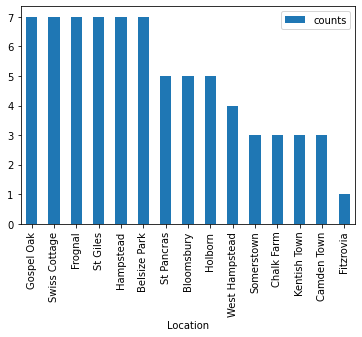

In [25]:
res_locations.plot(kind='bar',x='Location',y='counts')

So, as we can see in the bar plot above, St. Giles have the highest number of restaurants in this dataframe

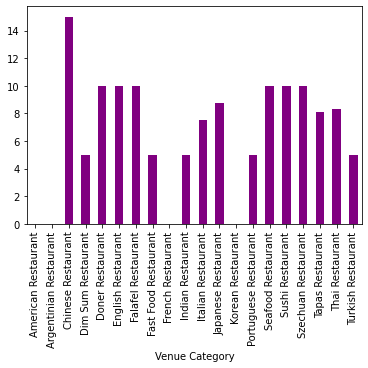

In [26]:
camden_restaurants.groupby('Venue Category')['HygieneScore'].mean().plot(kind='bar',color='purple')

The plot above shows the venue categories, along with their mean hygiene score

Let's list out number of locations in Camden that have good restaurant ratings and hygiene score 

In [27]:
filtered_restaurant = camden_restaurants[(camden_restaurants['HygieneScore']>8) & (camden_restaurants['RestaurantRating']>3)]
filtered_restaurant['Location'].value_counts()

Gospel Oak       3
Swiss Cottage    3
Hampstead        3
Frognal          3
Belsize Park     3
Fitzrovia        1
Name: Location, dtype: int64

As we can see except for Fitzrovia all other locations like Frognal, Swiss Cottage, Hapstead, Gospel Oak etc have at least two restaurants that have a good ratings and hygiene score.

Let's see which locations have higher average restaurant ratings.

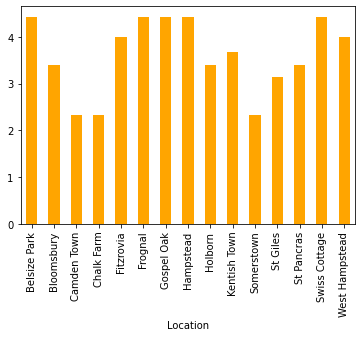

In [28]:
camden_restaurants.groupby('Location',axis=0).mean()['RestaurantRating'].plot(kind='bar',color='orange')

Let's see which restaurants have the highest ratings

In [29]:
camden_restaurants[camden_restaurants['RestaurantRating']==camden_restaurants['RestaurantRating'].max()]

,Location,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,RestaurantRating,HygieneScore,StructuralScore
21,Belsize Park,Spielburger,5377c796498e21d3bd43dbc0,51.556336,-0.178640,American Restaurant,5,0,0
29,Belsize Park,Carluccio's,4c0c9d27c700c9b6f730a1dd,51.554650,-0.172220,Italian Restaurant,5,5,5
43,Belsize Park,La Cage Imaginaire,4c4f4e9c92b6a593294f5a71,51.556736,-0.177311,French Restaurant,5,0,5
80,Bloomsbury,Casa Tua,572a73ed498ea7e4be325374,51.527580,-0.123635,Italian Restaurant,5,5,5
289,Frognal,Spielburger,5377c796498e21d3bd43dbc0,51.556336,-0.178640,American Restaurant,5,0,0
297,Frognal,Carluccio's,4c0c9d27c700c9b6f730a1dd,51.554650,-0.172220,Italian Restaurant,5,5,5
311,Frognal,La Cage Imaginaire,4c4f4e9c92b6a593294f5a71,51.556736,-0.177311,French Restaurant,5,0,5
342,Gospel Oak,Spielburger,5377c796498e21d3bd43dbc0,51.556336,-0.178640,American Restaurant,5,0,0
350,Gospel Oak,Carluccio's,4c0c9d27c700c9b6f730a1dd,51.554650,-0.172220,Italian Restaurant,5,5,5
364,Gospel Oak,La Cage Imaginaire,4c4f4e9c92b6a593294f5a71,51.556736,-0.177311,French Restaurant,5,0,5


Now let's see which restaurants have the highest hygiene score

In [30]:
camden_restaurants[camden_restaurants['HygieneScore']==camden_restaurants['HygieneScore'].max()]

,Location,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,RestaurantRating,HygieneScore,StructuralScore
123,Camden Town,Trufflesecco,57112d67498eebbbf735ec4f,51.534781,-0.139133,Italian Restaurant,2,15,5
157,Chalk Farm,Trufflesecco,57112d67498eebbbf735ec4f,51.534781,-0.139133,Italian Restaurant,2,15,5
604,Somerstown,Trufflesecco,57112d67498eebbbf735ec4f,51.534781,-0.139133,Italian Restaurant,2,15,5
682,St Giles,Canton Element,5273a803498e5eafdcc026d2,51.519931,-0.117408,Chinese Restaurant,0,15,20


Restaurants with the highest Structural Score

In [31]:
camden_restaurants[camden_restaurants['StructuralScore']==camden_restaurants['StructuralScore'].max()]

,Location,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,RestaurantRating,HygieneScore,StructuralScore
682,St Giles,Canton Element,5273a803498e5eafdcc026d2,51.519931,-0.117408,Chinese Restaurant,0,15,20


Finally, let's arrange the restaurants based on the ratings they have.

In [32]:
camden_restaurants.sort_values(by=['RestaurantRating'],inplace=True,ascending=False)
camden_restaurants

<ipython-input-32-6b567b7c8ed7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  camden_restaurants.sort_values(by=['RestaurantRating'],inplace=True,ascending=False)


,Location,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,RestaurantRating,HygieneScore,StructuralScore
827,West Hampstead,McDonald's,4b7800e8f964a520bbb12ee3,51.539607,-0.195667,Fast Food Restaurant,5,0,5
727,St Pancras,Casa Tua,572a73ed498ea7e4be325374,51.527580,-0.123635,Italian Restaurant,5,5,5
21,Belsize Park,Spielburger,5377c796498e21d3bd43dbc0,51.556336,-0.178640,American Restaurant,5,0,0
417,Hampstead,La Cage Imaginaire,4c4f4e9c92b6a593294f5a71,51.556736,-0.177311,French Restaurant,5,0,5
364,Gospel Oak,La Cage Imaginaire,4c4f4e9c92b6a593294f5a71,51.556736,-0.177311,French Restaurant,5,0,5
...,...,...,...,...,...,...,...,...,...
604,Somerstown,Trufflesecco,57112d67498eebbbf735ec4f,51.534781,-0.139133,Italian Restaurant,2,15,5
733,St Pancras,Chilli Cool,4add9af0f964a520236521e3,51.526703,-0.124751,Szechuan Restaurant,1,10,15
86,Bloomsbury,Chilli Cool,4add9af0f964a520236521e3,51.526703,-0.124751,Szechuan Restaurant,1,10,15
481,Holborn,Chilli Cool,4add9af0f964a520236521e3,51.526703,-0.124751,Szechuan Restaurant,1,10,15


Now its interesting that restaurants with good structural score and hygiene score have very low ratings.

<h2><em>4. Result</em></h2>

We were able to :
<ol>
    <li>Get the names of each borough in London along with the locations under each borough.</li>
    <li>Gather the coordinates for each locations.</li>
    <li>Gather the top venues in a borough.</li>
    <li>Obtain the required data for the restaurants like, name, location, category, rating, hygiene and structural scores.</li>
    <li>Explore the data regarding the restaurant and plot the requied plots.</li>
    <li>Plot the areas, and restaurants in a map.</li>
</ol>

<h2><em>5. Limitations</em></h2>

<ol>
<li>The model's accuracy is based on the accuracy of the data obtained.</li>
<li>There is a limitation on the number of API calls which restricts the amount of data which we can collect.</li>
</ol>

<h2>6. Conclusion</h2>

<p>This model can be used for obtaining the required data regarding venues like restaurants, bars, parks, cafes etc. Foursquare API can be used to get the required details regarding the venues in a given location. Also, this model can be used to recommend restaurants based on the location, type of cuisine, ratings, hygiene, quality of the place etc.</p>